## Example - Solving a first order differential equation using a PQK


This notebook demonstrates how to use sQUlearns's quantum kernels implementation to solve differential equations

### Imports

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel


from squlearn.util import Executor
from squlearn.encoding_circuit import ChebyshevTower
from squlearn.kernel import ProjectedQuantumKernel
from squlearn.kernel.loss import ODELoss
from squlearn.kernel import QKODE
from squlearn.optimizers import LBFGSB

We will use the Pennylane quantum framework for executing the circuits.

In [2]:
executor = Executor("pennylane", shots=None)

## `QKODE` Setup

We start by defining the parameterized quantum circuit (PQC), that calculates the quantum kernel $k^{\text{PQK}}(x,y)$

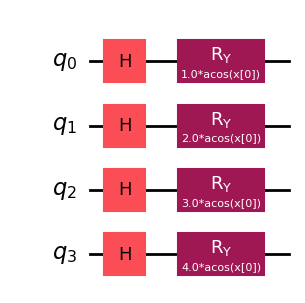

In [3]:
circuit = ChebyshevTower(num_qubits=4, num_features=1, num_chebyshev=4, num_layers=1)
circuit.draw("mpl")

Now, we can easily create the Projected Quantum Kernel instance that will be used to compute the kernel matrix.

In [4]:
pqk = ProjectedQuantumKernel(executor=executor, encoding_circuit=circuit)

We proceed to define the ODE to be solved, 

\begin{equation}
\frac{df(x)}{dx} - \lambda e^{-\lambda x k} \sin(\lambda x) - \lambda k f(x) = 0
\end{equation}


We create the homogeneous differential equation to be solved using a sympy symbolic expression


In [5]:
x, f, dfdx = sp.symbols("x f dfdx")
lamb, k = 10, 0.4
eq = dfdx - (-lamb * sp.exp(-lamb * x * k) * sp.sin(lamb * x) - lamb * k * f)
initial_values = [1]
eq

dfdx + 4.0*f + 10*exp(-4.0*x)*sin(10*x)

Now we need to create an instance of `ODELoss`, the symbols involved in the ODE must be provided in the correct order: independent variable, function, and higher orders

In [6]:
loss_ode_squ = ODELoss(
    eq,
    symbols_involved_in_ode=[x, f, dfdx],
    initial_values=initial_values,
    eta=1,
)

An instance of `QKODE` is created. The instance takes the kernel of choice, the loss function and the optimizer to be used

In [7]:
np.random.seed(0)
x_train = np.linspace(0, 0.9, 30).reshape(-1, 1)
x_test = np.sort((np.random.rand(60, 1) * 0.9), axis=0).reshape(
    -1, 1
)  # create randomly distributed test data

labels = np.zeros((len(x_train), 1))
# parameter_values = np.random.rand(len(x_train) + 1)  # initial parameter values
optimizer = LBFGSB()

model = QKODE(pqk, loss_ode_squ, optimizer)
model.fit(x_train, labels)

QKODE(alpha=None,
      quantum_kernel=<squlearn.kernel.lowlevel_kernel.projected_quantum_kernel.ProjectedQuantumKernel object at 0x000002981C1BC880>)

### Evaluation

Let's print the optimal parameters of the QK ansatz and operator

In [8]:
model.dual_coeff_

array([ 0.038881  ,  2.30016895, -0.22541764, -1.05711248, -0.6920442 ,
        0.32950377,  0.39746725,  0.43765704, -0.10311711, -0.89196733,
       -0.14782569,  0.07772397,  0.29669418,  0.48483058, -0.5191364 ,
       -0.34119852, -0.11560331,  0.66233686,  0.10749785, -0.319285  ,
       -0.19306952,  0.13053353,  0.1396035 ,  0.28756084, -0.58370915,
        0.22726508, -0.00323114,  0.25461318, -0.5483683 ,  0.43692297,
       -0.20345201])

And plot the solution

Text(0, 0.5, 'f')

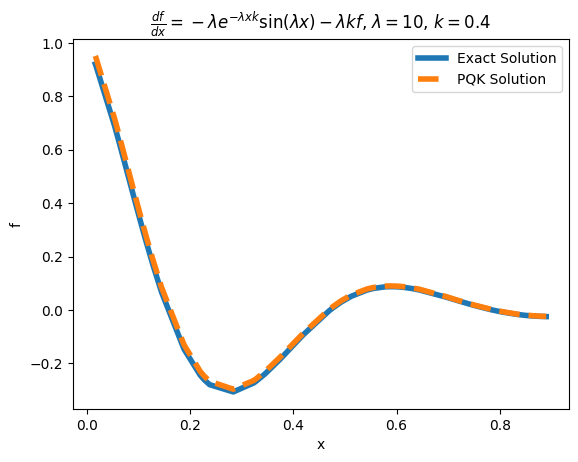

In [9]:
plt.plot(
    x_test, np.exp(-10 * x_test * 0.4) * np.cos(10 * x_test), label="Exact Solution", linewidth=4
)
plt.plot(x_test, model.predict(x_test), label="PQK Solution", linewidth=4, linestyle="--")
plt.legend()
plt.title(
    r"$\frac{df}{dx} = -\lambda e^{-\lambda x k} \sin(\lambda x) - \lambda k f$, $\lambda = 10$, $k = 0.4$"
)
plt.xlabel("x")
plt.ylabel("f")

We can also use precomputed kernel matrices to solve the differential equation. Here, we will use a classical RBF kernel,  $ k(x, y) = \exp(-\frac{||x - y||^2}{2\sigma^2}) = \exp(-\gamma||x - y||^2) $

In [10]:
def RBF_K(x, y, sigma=1):
    return rbf_kernel(x, y, gamma=1 / (2 * sigma**2))


def RBF_dKdx(x, y, sigma=1):
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).reshape(-1, 1)
    X, Y = np.meshgrid(x, y, indexing="ij")
    rbf_values = rbf_kernel(x, y, gamma=1 / (2 * sigma**2))
    derivative = rbf_values * (-(X - Y) / sigma**2)
    return derivative

Text(0, 0.5, 'f')

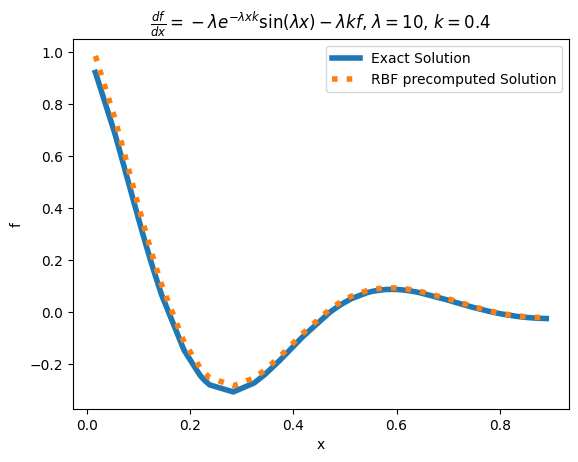

In [11]:
l = 0.15
K_RBF = RBF_K(x_train, x_train, l)
dKdx_RBF = RBF_dKdx(x_train, x_train, l)

model_precomputed = QKODE("precomputed", loss_ode_squ, optimizer, K_RBF, dKdx_RBF)

model_precomputed.fit(x_train, labels)
K_testtrain = RBF_K(x_test, x_train, l)

plt.plot(
    x_test, np.exp(-10 * x_test * 0.4) * np.cos(10 * x_test), label="Exact Solution", linewidth=4
)
plt.plot(
    x_test,
    model_precomputed.predict(K_testtrain),
    label="RBF precomputed Solution",
    linewidth=4,
    linestyle=":",
)

plt.legend()
plt.title(
    r"$\frac{df}{dx} = -\lambda e^{-\lambda x k} \sin(\lambda x) - \lambda k f$, $\lambda = 10$, $k = 0.4$"
)

plt.xlabel("x")
plt.ylabel("f")